# Multi-Year Analysis of RoadSafety

## Authors: Vijaysrinivas Rajagopal, Abhishek Ravi, Tyler Nguyen, and Jarod Jeklin

### Summary:
This final project for COSC445 attempts to analyze highway accidents across the United States from the years 2010, 2014, and 2018. We found that in some cases higher speed limits did indicate to some states being higher on the list for either cumulative or normalized accidents. Although, it should be noted that this correlation is fairly weak and can change with different years. For future work, we would like to incorporate more FARS data from years past 2010 as well as other features from other datasets, such as the highway integrity and highway network length.

### Datasets:
This notebook utilizes various datasets in order to accomplish this analysis, such as:

- FARS Raw Dataset in CSV format (2010, 2014, and 2018)
- United States Census Data (cumulative history from the 2019 edition)
- [GADM](https://gadm.org/download_country_v3.html) (Shape files for cartopy)
- [Wikipedia Speed Limits in the United States](https://en.wikipedia.org/wiki/Speed_limits_in_the_United_States)

### Related Packages:
This notebook employs the following Python packages that help in processing data as well as visualizing it:
- GeoJSON
- Matplotlib
- Pandas
- Seaborn
- Cartopy
- TQDM

## Setup:

In [1]:
from config import config
import parser
import os
import sys
import geojson
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
import random
import pandas as pd
import csv
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from matplotlib.colors import ListedColormap
from tools import *

## Environment Setup Code

In [66]:
years = [2010,2014,2018]

# Parse census data:
with open('nst-est2019-alldata.csv') as censusCSV:
    census = list(csv.reader(censusCSV))
    header = census[0]
    
# Parse speed limit data:
speed_limits = pd.DataFrame(parser.readSpeed('highway_speed.csv'))

def grabCensusYear(year): 
    index_check = []
    for i, item in enumerate(header):
        if str(year) in item:
            index_check.append(i)
            break
    return index_check[0] # just for POPESTIMATE2018 (Population Estimate; might need some other fields later)

print('Maximum Speed Limit of States (freeway urban)')
print(speed_limits[:10])
print("...")
print("=====================================")

yearPop = []
for year in years:
    _in = grabCensusYear(year)
    popEst = pd.DataFrame([(int(census[y][3]),census[y][4], int(census[y][_in])) for y in range(1,len(census)) if int(census[y][3]) > 0])
    yearPop.append(popEst)
    print("Estimated Population in %i"%year)
    print(popEst[:10])
    print("...")
    print("=====================================")

Maximum Speed Limit of States (freeway urban)
               0   1
0         Hawaii  50
1       New York  55
2       Maryland  65
3   Pennsylvania  70
4    Connecticut  55
5      Minnesota  60
6  Massachusetts  65
7        Florida  70
8       Illinois  70
9       Missouri  70
...
Estimated Population in 2010
    0                     1         2
0   1               Alabama   4779736
1   2                Alaska    710231
2   4               Arizona   6392017
3   5              Arkansas   2915918
4   6            California  37253956
5   8              Colorado   5029196
6   9           Connecticut   3574097
7  10              Delaware    897934
8  11  District of Columbia    601723
9  12               Florida  18801310
...
Estimated Population in 2014
    0                     1         2
0   1               Alabama   4841799
1   2                Alaska    736283
2   4               Arizona   6730413
3   5              Arkansas   2967392
4   6            California  38596972
5   8      

In [15]:
# import cartopy stuff:
us_shapes = list(shpreader.Reader('shapes/gadm36_USA_1.shp').geometries())
year_accidents = []

# import parser data:
for year in years:
    fars_years = parser.generateFARS(year)
    fars_2018_files = parser.grabFiles(fars_years)
    enum = list(enumerate(fars_2018_files))
    enum = list(map(str.lower,[i[1] for i in enum]))
    index = enum.index('accident.csv')
    print("Reading %s file: "%fars_years, fars_2018_files[index])

    category = parser.grabCat(fars_2018_files)
    cat = category[index]
    accidents = parser.csvRead(os.path.join(parser.ROOT, fars_years, fars_2018_files[index]), cat)
    year_accidents.append(accidents)

Reading FARS2010NationalCSV file:  ACCIDENT.CSV
Reading FARS2014NationalCSV file:  ACCIDENT.csv
Reading FARS2018NationalCSV file:  ACCIDENT.csv


### Example of Accident Files:

FARS (Fatality Analysis Reporting System) is a comprehensive program from the NHTSA that accumulates, tabulates, and publishes all known automobile accidents in all fifty states as well as US territories (but in our case, only the fifty states are considered in this analysis). FARS puts out a large report every year on the trends of automobile fatalities and accidents, noting any significant trends or lack there of. Additionally, FARS publishes their raw dataset for that given year. This raw dataset is in multiple formats, including CSV, and contain multiple CSV files that detail different aspects of automobile accidents in the United States.

In the case of this analysis, the major file used was **ACCIDENT.csv**, which contained an already tremendous amount of metadata on every single accident recorded that year. This includes, but not limited to, details such as the coordinates of the accident, major street the accident occurred on, the precise date the accident was recorded, how many fatalities in a given accident, road conditions (multiple fields) during the accident, and the car models involved in the accident.

Due to the nature of the analysis, we decided to narrow down our usage to only the state and major road where a given accident occurred. In the cell below, you will see some example entries from the FARS 2018 ACCIDENT.csv.

**Important Note:** It should be noted that FARS has many discrepancies between each reporting year. Although this issue was mostly resolved since the standardization of reports in 2010 (more details can be found [here](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/811564)), there are slight different in things such as vehicle codes and even filenames (FARS 2010 named our given csv file **ACCIDENTS.CSV** instead of **ACCIDENTS.csv**).

In [16]:
# Show example rows of ACCIDENT.csv
example = random.choices(year_accidents[0], k=5)
df = pd.DataFrame(example)
df.style

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PEDS,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,ROAD_FNC,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,REL_ROAD,WRK_ZONE,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,37,370611,1,1,1,3,155,0,27,7,2010,3,23,49,1,2,2,US-74,,99999,34.719886,-79.313222,0,8,0,0,1,1,1,0,2,1,0,1,0,0000000,23,53,23,57,88,88,0,0,0,1,0
1,46,460068,1,1,0,2,87,0,7,8,2010,7,18,35,1,1,1,I-90 W,,3648,43.666311,-97.370603,0,1,0,0,1,1,4,0,1,1,0,1,0,0000000,99,99,99,99,99,99,0,0,0,1,0
2,8,80391,1,1,0,1,37,0,17,12,2010,6,0,30,0,4,2,US-6,,1502,39.659656,-106.815872,0,1,0,0,1,1,4,0,2,1,0,1,0,0000000,0,35,0,40,88,88,0,0,0,1,1
3,13,130227,1,1,0,2,115,0,3,4,2010,7,22,25,0,15,4,TURNER CHAPEL ROAD,,15,34.240844,-85.130761,0,35,0,0,1,1,6,0,2,1,0,1,0,0000000,22,29,22,37,23,2,0,0,0,1,1
4,48,481708,2,1,0,3,439,2450,20,5,2010,5,17,12,1,11,1,I-20,,61,32.700878,-97.472044,0,14,0,1,19,1,2,0,1,10,0,10,0,0000000,17,25,17,38,18,0,0,0,0,1,0


## Normalized Cummulative Accidents on Highways

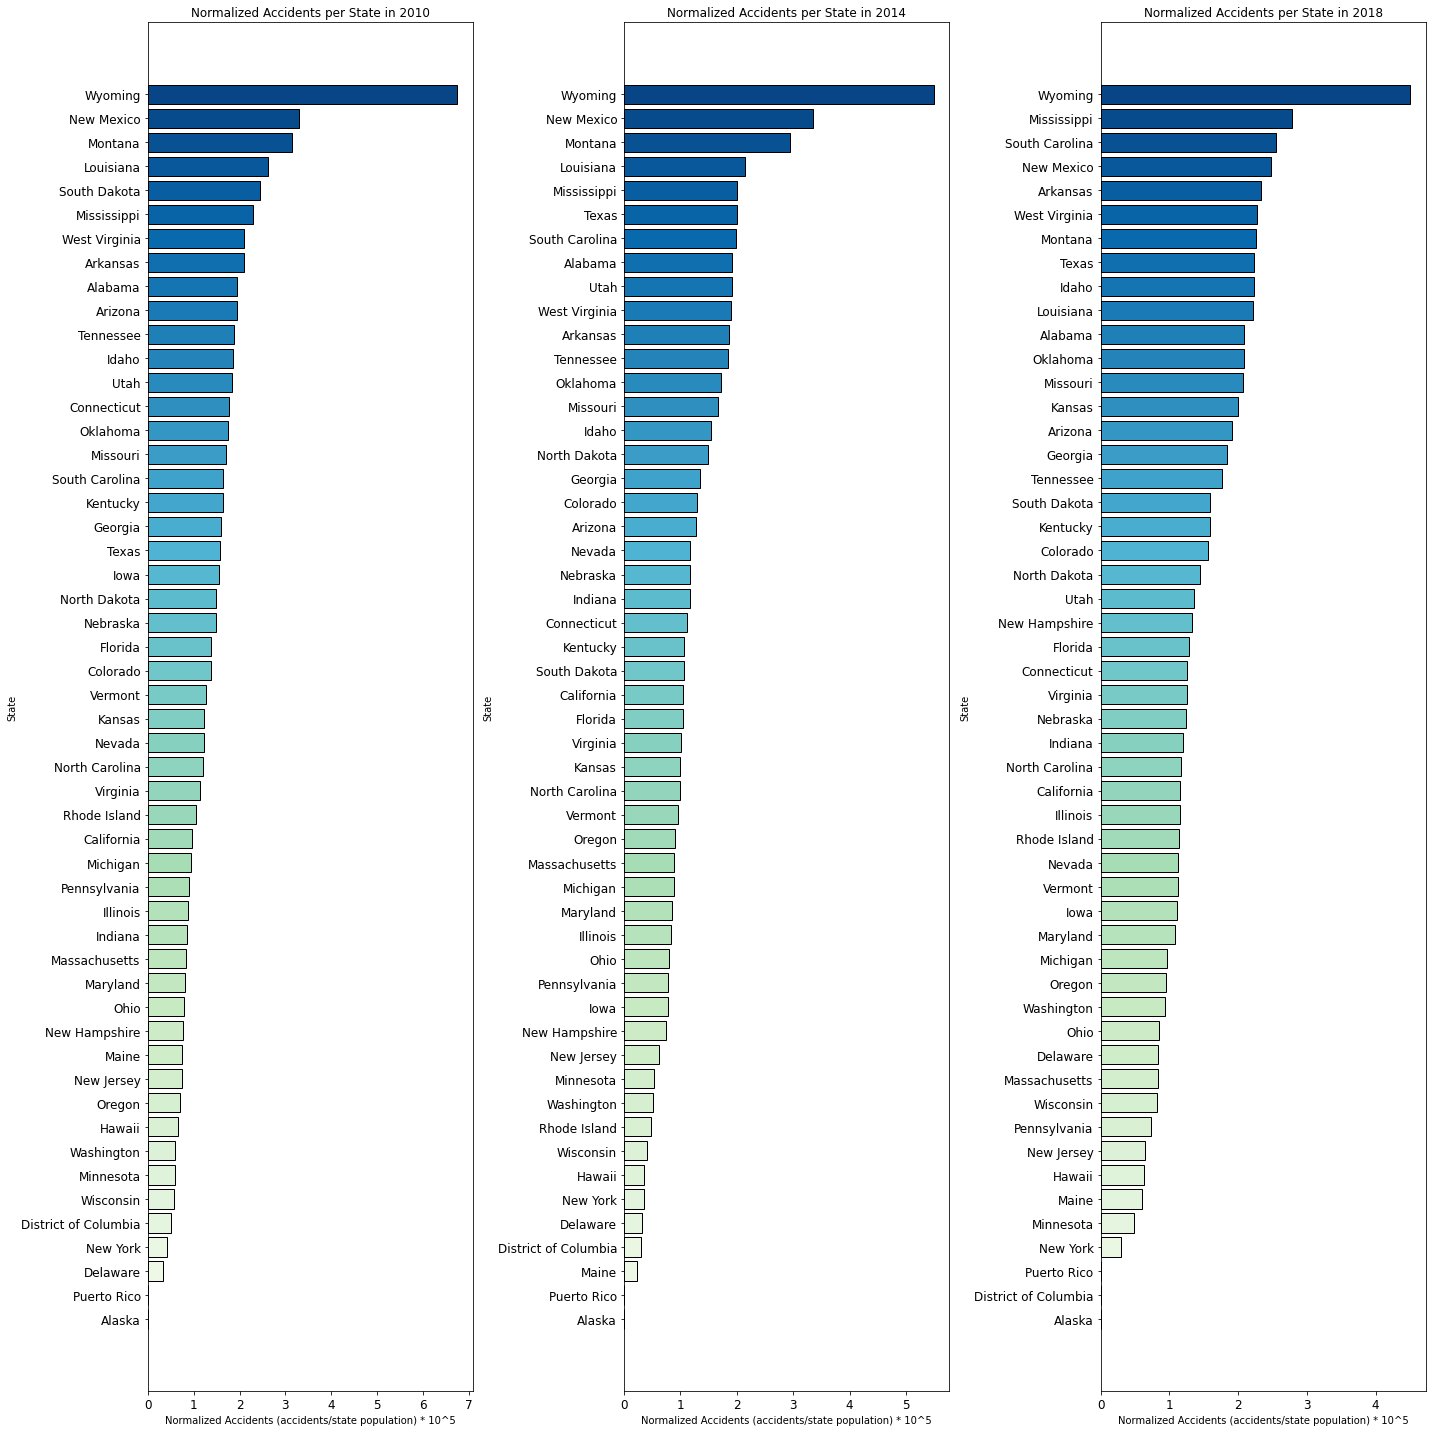

In [17]:
# Subplot and Enter All of Them:
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,3,1)
accident,yr,popEst = year_accidents[0],years[0],yearPop[0]  
_INTER_X, _INTER_Y, TOTAL_Y = generateGraphData(accident, popEst)
GnBu = sns.color_palette('GnBu', len(_INTER_X))
plt.barh(_INTER_X,_INTER_Y, align='center', color=GnBu, edgecolor='black')
plt.title('Normalized Accidents per State in %i'%yr)
ax1.set_ylabel('State')
ax1.set_xlabel('Normalized Accidents (accidents/state population) * 10^5')
 
ax2 = fig.add_subplot(1,3,2)
accident,yr,popEst = year_accidents[1],years[1],yearPop[1] 
_INTER_X, _INTER_Y, TOTAL_Y = generateGraphData(accident, popEst)
GnBu = sns.color_palette('GnBu', len(_INTER_X))
plt.barh(_INTER_X,_INTER_Y, align='center', color=GnBu, edgecolor='black')
plt.title('Normalized Accidents per State in %i'%yr)
ax2.set_ylabel('State')
ax2.set_xlabel('Normalized Accidents (accidents/state population) * 10^5')

ax3 = fig.add_subplot(1,3,3)
accident,yr,popEst = year_accidents[2],years[2],yearPop[2] 
_INTER_X, _INTER_Y, TOTAL_Y = generateGraphData(accident, popEst)
GnBu = sns.color_palette('GnBu', len(_INTER_X))
plt.barh(_INTER_X,_INTER_Y, align='center', color=GnBu, edgecolor='black')
plt.title('Normalized Accidents per State in %i'%yr)
ax3.set_ylabel('State')
ax3.set_xlabel('Normalized Accidents (accidents/state population) * 10^5')
fig.tight_layout()
plt.show()

## Analysis

With the normalized data visualized, it can be seen that **Wyoming**, a state with a sparse population relative to the rest of the United States, had the most accidents per population. The extent to which Wyoming's normalized accident rate leads all other states is quite surprising. This could be because of multiple factors, including the regional weather, the highway conditions, or the possible factor of out-of-state vehicles travel within the state.

In terms of the other states, there are small differences between states and their ranked neighbors. Many of the top ten states (not including Wyoming) have a tendency to switch places with one another, but there does not seem to be any drastic movement of states between 2010 to 2014 or 2014 to 2018.

## Raw Cummulative Accident on Highways:

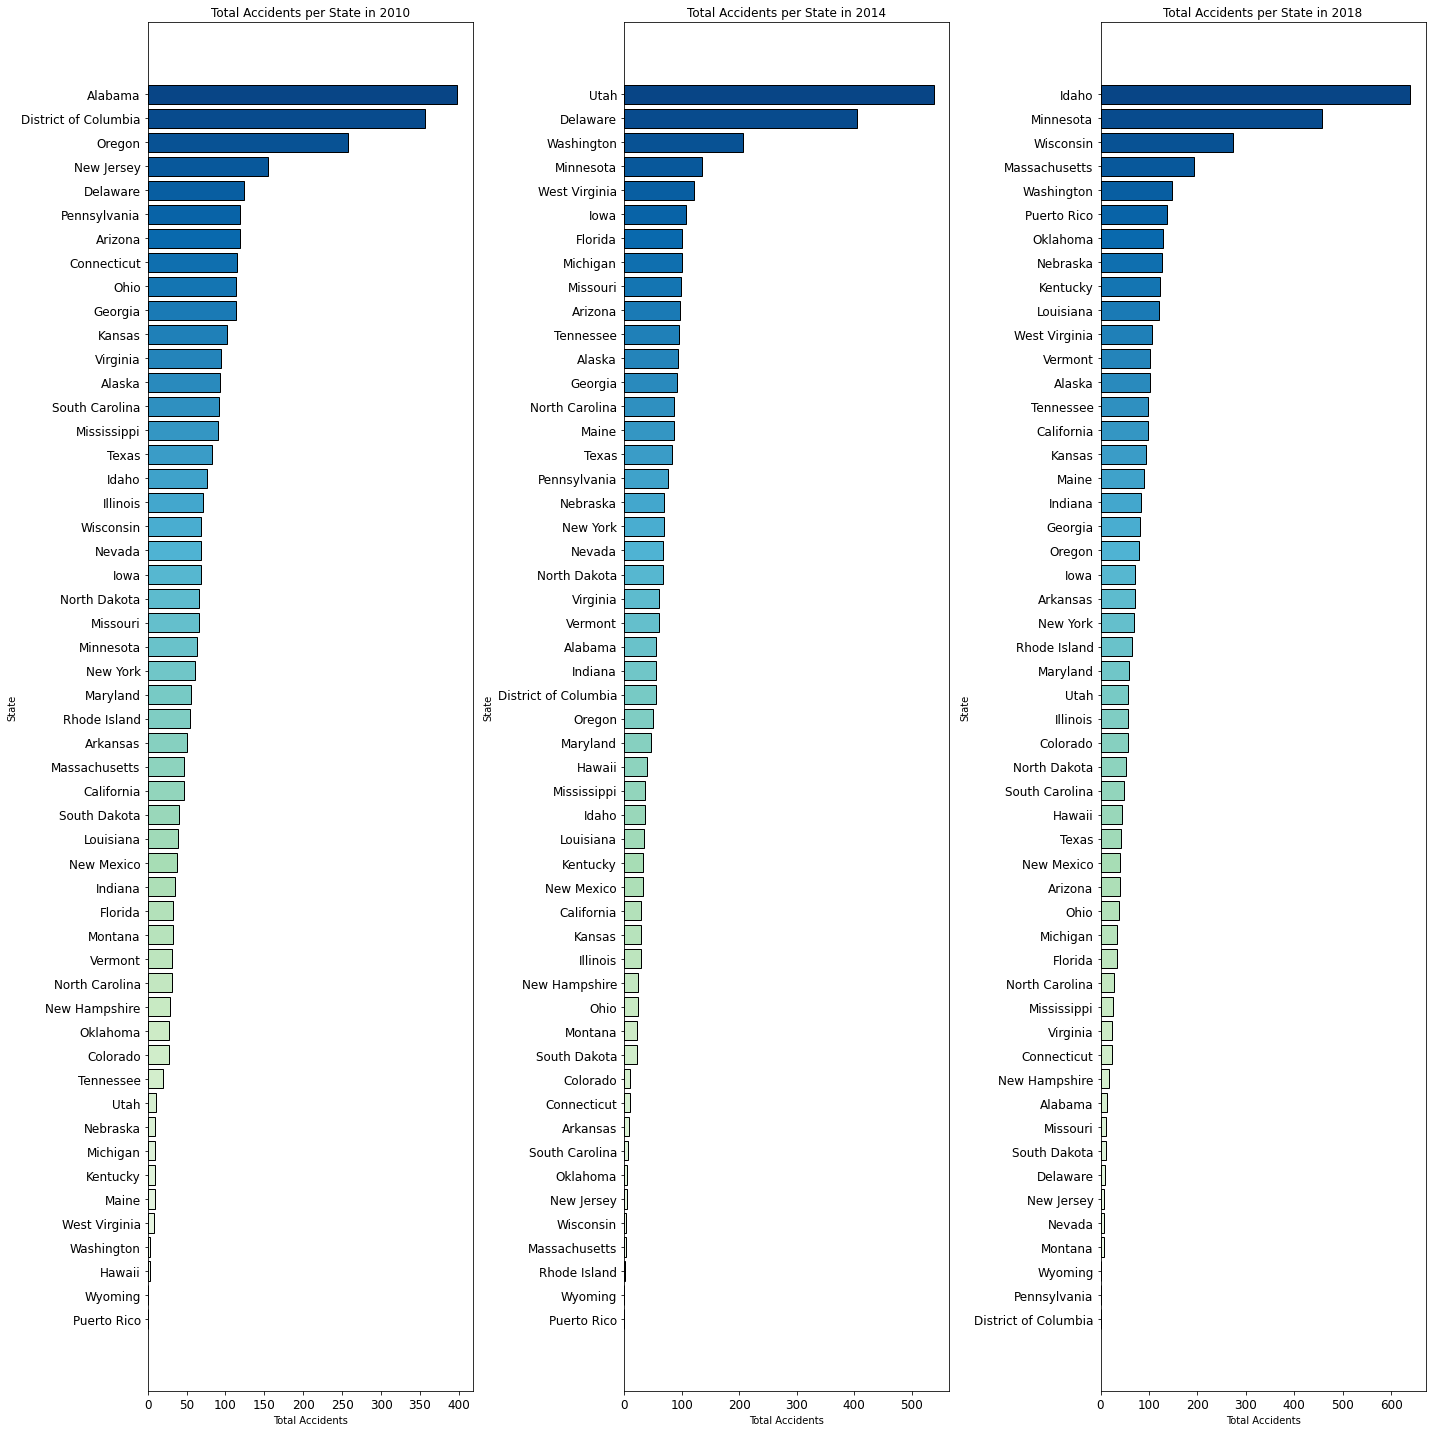

In [72]:
# Subplot and Enter All of Them:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,3,1)
accident,yr,popEst = year_accidents[0],years[0],yearPop[0]
INTER_X, INTER_Y, TOTAL_Y = generateGraphData(accident, popEst)

_INTER_X, _INTER_Y = [], []
INTER_COM = sorted(zip(TOTAL_Y,INTER_X))
for y,x in INTER_COM:
    _INTER_X.append(x)
    _INTER_Y.append(y)
    
GnBu = sns.color_palette('GnBu', len(_INTER_X))
plt.barh(_INTER_X,_INTER_Y, align='center', color=GnBu, edgecolor='black')
plt.title('Total Accidents per State in %i'%yr)
ax1.set_ylabel('State')
ax1.set_xlabel('Total Accidents')
 
ax2 = fig.add_subplot(1,3,2)
accident,yr,popEst = year_accidents[1],years[1],yearPop[1]
INTER_X, INTER_Y, TOTAL_Y = generateGraphData(accident, popEst)

_INTER_X, _INTER_Y = [], []
INTER_COM = sorted(zip(TOTAL_Y,INTER_X))
for y,x in INTER_COM:
    _INTER_X.append(x)
    _INTER_Y.append(y)

GnBu = sns.color_palette('GnBu', len(_INTER_X))
plt.barh(_INTER_X,_INTER_Y, align='center', color=GnBu, edgecolor='black')
plt.title('Total Accidents per State in %i'%yr)
ax2.set_ylabel('State')
ax2.set_xlabel('Total Accidents')

ax3 = fig.add_subplot(1,3,3)
accident,yr,popEst = year_accidents[2],years[2],yearPop[2] 
INTER_X, INTER_Y, TOTAL_Y = generateGraphData(accident, popEst)

_INTER_X, _INTER_Y = [], []
INTER_COM = sorted(zip(TOTAL_Y,INTER_X))
for y,x in INTER_COM:
    _INTER_X.append(x)
    _INTER_Y.append(y)

GnBu = sns.color_palette('GnBu', len(_INTER_X))
plt.barh(_INTER_X,_INTER_Y, align='center', color=GnBu, edgecolor='black')
plt.title('Total Accidents per State in %i'%yr)
ax3.set_ylabel('State')
ax3.set_xlabel('Total Accidents')
fig.tight_layout()
plt.show()

## Analysis

Rather than normalizing the accident data, it might prove useful to see the raw cumulative total of accidents in each state. The chart above does this for all chosen years, and it can be seen that there are very interesting differences between this chart and the normalized chart. Firstly, there is no consistent leader for top cumulative accidents. Furthermore, the ordering of the states has far more variation than the normalized data. This indicates that cumulative accident totals in the same state can differ greatly between years.

## Heatmap Visualization:

This section of the analysis is visualizing the data from before in a new way in order to show the specific locations within the states of where these accidents are happening. It might be obvious, but with these heatmaps, we can see that most accidents happen around areas of high population densities (mainly cities). This can be attributed to the mere fact that more cars interacting with other cars increases the probability of such cars getting into some sort of accident.


**NOTE:** It can be seen the next subsection that the Heatmap for 2010 is not working properly. Unfortunately at this time, the reason behind this is currently unknown.

### Heatmap for 2010 (Broken for some reason):

Number of accidents in 2018 US: 30296
regular_lat:  69.85037222 regular_lng:  1048.39190556
max_lng:  888.8888 min_lng:  -159.50310556
max_lat:  88.8888 min_lat:  19.03842778
(600, 300) (600,) (300,)
(300, 600)


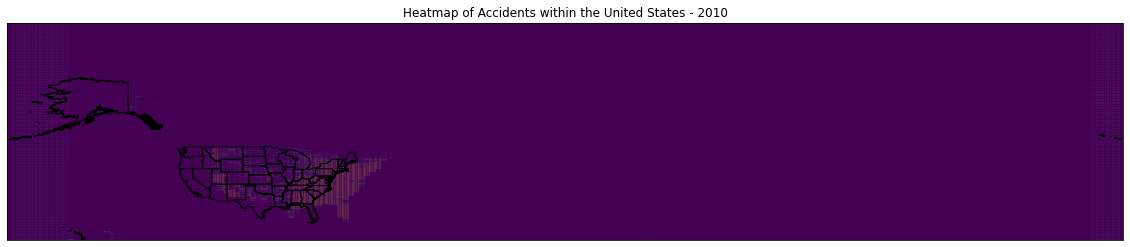

In [19]:
year_acc, yr = year_accidents[0], years[0]
acc_tuple = accidentAmount(year_acc)
extent, max_lat, min_lat, max_lng, min_lng, regular_lat, regular_lng = generateMapBounds(acc_tuple)
packaged = (max_lat, max_lng, min_lat, min_lng, regular_lat, regular_lng)
_map = generateMap(acc_tuple, extent, yr, us_shapes, packaged)

### Heatmap for 2014:

Number of accidents in 2018 US: 30056
regular_lat:  49.349391669999996 regular_lng:  98.30103335999999
max_lng:  -67.10606944 min_lng:  -165.4071028
max_lat:  68.43376389 min_lat:  19.08437222
(600, 300) (600,) (300,)
(300, 600)


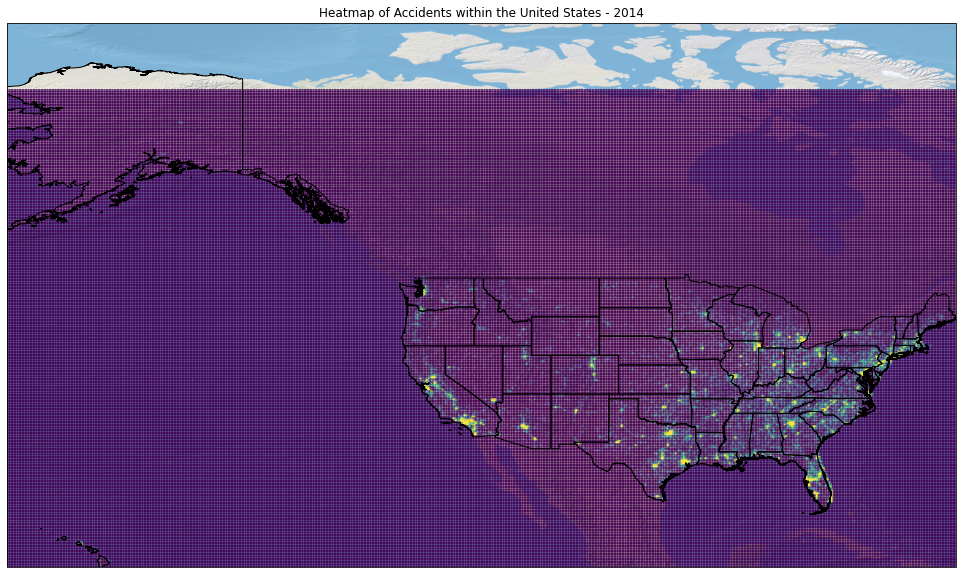

In [20]:
year_acc, yr = year_accidents[1], years[1]
acc_tuple = accidentAmount(year_acc)
extent, max_lat, min_lat, max_lng, min_lng, regular_lat, regular_lng = generateMapBounds(acc_tuple)
packaged = (max_lat, max_lng, min_lat, min_lng, regular_lat, regular_lng)
_map = generateMap(acc_tuple, extent, yr, us_shapes, packaged)

### Heatmap for 2018:

Number of accidents in 2018 US: 33654
regular_lat:  50.61651666 regular_lng:  96.01705559
max_lng:  -67.01511111 min_lng:  -163.0321667
max_lat:  69.73334722 min_lat:  19.11683056
(600, 300) (600,) (300,)
(300, 600)


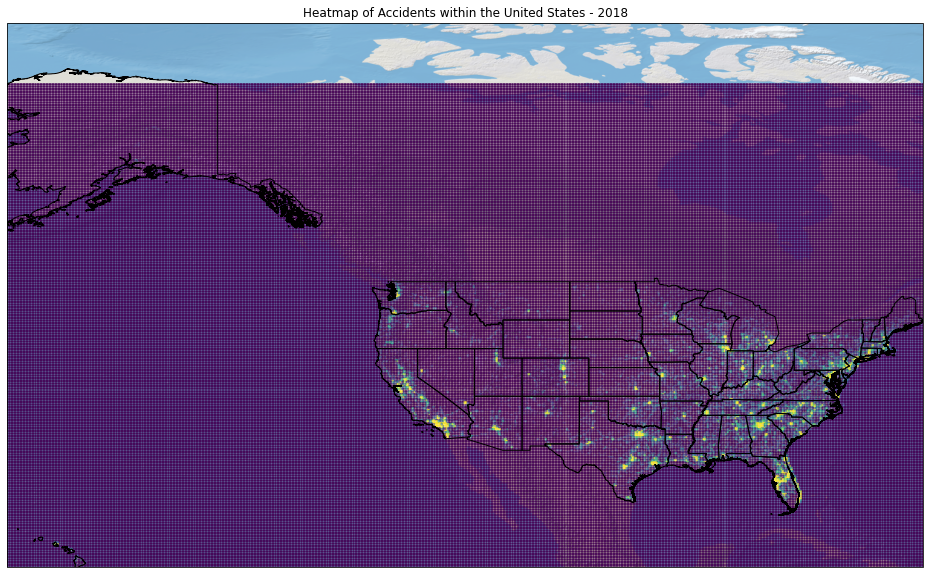

In [21]:
year_acc, yr = year_accidents[2], years[2]
acc_tuple = accidentAmount(year_acc)
extent, max_lat, min_lat, max_lng, min_lng, regular_lat, regular_lng = generateMapBounds(acc_tuple)
packaged = (max_lat, max_lng, min_lat, min_lng, regular_lat, regular_lng)
_map = generateMap(acc_tuple, extent, yr, us_shapes, packaged)

In [71]:
from IPython.display import display, HTML, display_html 
# visualizing speed limits in different states:
#fig = plt.figure(figsize=(20,20))
_x, _y = [],[]
for i in sorted(zip(speed_limits[1], speed_limits[0])):
    _x.append(i[1])
    _y.append(i[0])
    
'''
plt.barh(_x, _y)
plt.xlabel('Maximum Speed on Freeway (urban)')
plt.ylabel('State')
plt.title('Maximum Speed Limit per State')
plt.show()
'''

speed = pd.DataFrame([(_x[i], _y[i])for i in range(len(_x))], columns=['State', 'Speed Limit'])
display(speed)
print("Note: This is maximum speed limit on a freeway in urban settings")

,State,Speed Limit
0,Hawaii,50
1,Connecticut,55
2,District of Columbia,55
3,New York,55
4,Puerto Rico,55
5,Rhode Island,55
6,Vermont,55
7,Minnesota,60
8,Oregon,60
9,South Carolina,60


Note: This is maximum speed limit on a freeway in urban settings


In [63]:
from IPython.display import display, HTML, display_html 
accident,yr,popEst = year_accidents[2],years[2],yearPop[2]  
_INTER_X, _INTER_Y, TOTAL_Y = generateGraphData(accident, popEst)

# normalized top ten:
normal_top10 = pd.DataFrame(_INTER_X[-10:], columns=['State'])
normal_top10 = normal_top10.reindex(index=normal_top10.index[::-1])

# standard top ten:
_INTER_X, _INTER_Y = [], []
INTER_COM = sorted(zip(TOTAL_Y,INTER_X))
for y,x in INTER_COM:
    _INTER_X.append(x)
    _INTER_Y.append(y)
unnormal_top10 = pd.DataFrame(_INTER_X[-10:], columns=['State'])
unnormal_top10 = unnormal_top10.reindex(index=unnormal_top10.index[::-1])

# speed limits:
speed_top10 = pd.DataFrame(_x[-10:], columns=['State'])
speed_top10 = speed_top10.reindex(index=speed_top10.index[::-1])

normal_styler = normal_top10.style.set_table_attributes("style='display:inline; margin-right: 20px'").set_caption('Normalized Accidents')
unnormal_styler = unnormal_top10.style.set_table_attributes("style='display:inline; margin-right: 20px'").set_caption('Cummulative Accidents')
speed_styler = speed_top10.style.set_table_attributes("style='display:inline'").set_caption('Speed Limits')

display_html(normal_styler._repr_html_()+unnormal_styler._repr_html_()+speed_styler._repr_html_(), raw=True)

,State
9,Wyoming
8,Mississippi
7,South Carolina
6,New Mexico
5,Arkansas
4,West Virginia
3,Montana
2,Texas
1,Idaho
0,Louisiana


# Analysis

In the previous cell, we only took the top ten states from all types of computed data (normalized accidents, cumulative accidents, and speed limits) for 2018 in order to find some sort of relationship between the first two with the speed limit table.

It can be seen that Wyoming, with a speed limit of 75 MPH, is one of the highest in the nation and it correlates with the highest normalized accident rate in 2018. This can also be seen to a certain extent with the 2nd highest speed limit state, Texas. This state can be seen the normalized table at 8th place. On the other hand, states such as South and North Dakota are not in either accident table, which can indicate that there are many more factors related to driver behavior and typical road conditions that influences the rate at which accidents occur within a given state.